# Detecting COVID-19 and Viral Pneumonia with Chest X Ray and Lung Segmentation Mask using PyTorch By Fahim-Ul-Islam


Image classification of Chest X Rays in one of 3 classes: Normal, COVID-19, Viral Pneumonia

Dataset from [COVID-QU-Ex Dataset](https://www.kaggle.com/datasets/anasmohammedtahir/covidqu) on Kaggle

# Importing Libraries

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import torch.nn as nn
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torchsummary
import pytorch_model_summary
from torchsummary import summary
%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

# to find the index of your GPU in PyTorch:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device index: {torch.cuda.current_device()}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")

#To check if your PyTorch code has been built with GPU support, you can use the following code:

print(torch.version.cuda)  # This will print the version of CUDA used by PyTorch
print(torch.cuda.is_available())  # This will print whether PyTorch has access to a GPU
print(torch.backends.cudnn.enabled)  # This will print whether the cuDNN library is enabled for GPU acceleration

#For TensorFlow, you can use the following code to check if your code is using GPU:



Using PyTorch version 2.0.1
GPU device index: 0
11.8
True
True


# Preparing Training and Test Sets

# Creating Custom Dataset

In [ ]:
import os
import random
import torch
from PIL import Image
import torchvision.transforms as transforms

class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, mask_dirs, image_transform, mask_transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('.png')]
            masks = [x for x in os.listdir(mask_dirs[class_name]) if x.lower().endswith('.png')]
            print(f'Found {len(images)} {class_name} examples')
            return images, masks

        self.images = {}
        self.masks = {}
        self.class_names = ['normal', 'covid', 'non-covid']

        for c in self.class_names:
            self.images[c], self.masks[c] = get_images(c)

        self.image_dirs = image_dirs
        self.mask_dirs = mask_dirs
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        mask_name = self.masks[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        mask_path = os.path.join(self.mask_dirs[class_name], mask_name)
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale

        # Get the index of the class label
        class_label = self.class_names.index(class_name)

        return self.image_transform(image), self.mask_transform(mask), class_label




# Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(299, 299)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(299, 299)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(256, 256)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
mask_transfor = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])


# Prepare DataLoader

In [ ]:
train_dirs = {
    'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/Normal/images',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/COVID-19/images',
    'non-covid' : 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/Non-COVID/images'
}

In [ ]:
train_mask_dirs = {
    'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/Normal/lung masks',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/COVID-19/lung masks',
    'non-covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/Non-COVID/lung masks'
}

In [ ]:
train_dataset = ChestXRayDataset(train_dirs, train_mask_dirs, train_transform,mask_transfor )

Found 6849 normal examples
Found 7658 covid examples
Found 7208 non-covid examples


In [ ]:
test_dirs = {
     'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/Normal/images',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/COVID-19/images',
    'non-covid' : 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/Non-COVID/images'
}

In [ ]:
test_mask_dirs = {
    'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/Normal/lung masks',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/COVID-19/lung masks',
    'non-covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/Non-COVID/lung masks'
}

In [ ]:
test_dataset = ChestXRayDataset(test_dirs, test_mask_dirs, test_transform,mask_transfor )

Found 2140 normal examples
Found 2395 covid examples
Found 2253 non-covid examples


In [ ]:
val_dirs = {
 'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/Normal/images',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/COVID-19/images',
    'non-covid' : 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/Non-COVID/images'
}

In [ ]:
val_mask_dirs = {
    'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/Normal/lung masks',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/COVID-19/lung masks',
    'non-covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/Non-COVID/lung masks'
}

In [ ]:
val_dataset = ChestXRayDataset(val_dirs, val_mask_dirs, val_transform,mask_transfor )

Found 1712 normal examples
Found 1903 covid examples
Found 1802 non-covid examples


In [ ]:
batch_size = 4


dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


print('Number of training batches:', len(dl_train))
print('Number of test batches:', len(dl_test))
print('Number of test batches:', len(dl_val))

Number of training batches: 5429
Number of test batches: 1697
Number of test batches: 1355


# Creating the Model

In [ ]:
import torchvision.models as models

# resnet18 = torchvision.models.resnet18(pretrained = True)
#
# vgg16 = torchvision.models.vgg16(pretrained = True)
#
# alex = torchvision.models.alexnet(pretrained = True)
#
# inception = models.inception_v3(pretrained=True)
#
#
#
# densenet = models.densenet169(pretrained=True)
#
# print(densenet)
#
# print(resnet18)
#
# print(vgg16)
#
# print(alex)
#
# print(inception)

In [ ]:




# num_ftrs = resnet18.fc.in_features
#
# resnet18.fc = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, 32),  # Reduce hidden units from 64 to 32
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Dropout(p=0.5),  # Decrease dropout rate from 0.9 to 0.5
#     torch.nn.Linear(32, 3)  # Keep the final layer as it is
# )
# # loss_fn = torch.nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.25e-5)
# #
# #
#
#
#
#

In [ ]:
# # Freeze all layers except the last
# for param in densenet.parameters():
#     param.requires_grad = False
#
# # Replace the last fully connected layer with a new one
# num_ftrs = densenet.classifier.in_features
# dropout_prob = 0.8
# densenet.classifier = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, 128),  # num_ftrs divided by 4
#     torch.nn.ReLU(),
#     torch.nn.Dropout(p=dropout_prob),
#     torch.nn.Linear(128, 64),  # 512 divided by 4
#     torch.nn.ReLU(),
#     torch.nn.Dropout(p=0.001),
#     torch.nn.Linear(64, 3)  # 256 divided by 4
# )
# # # Define the loss function and optimizer
# # loss_fn = torch.nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(densenet.parameters(), lr=0.05e-5)

In [ ]:

# # Replace the last fully connected layer to have 3 output features
# num_features = vgg16.classifier[-1].in_features
# vgg16.classifier[-1] = nn.Linear(num_features, 3)
#
# # Add dropout layer after the first fully connected layer
# vgg16.classifier[0] = nn.Sequential(
#     nn.Linear(25088, 4096),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.8),
# )
#
# # # Set loss function and optimizer
# # loss_fn = torch.nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(vgg16.parameters(), lr = 0.45e-5)

In [ ]:

# for name, param in alex.named_parameters():
#     if name not in ['classifier.6.weight', 'classifier.6.bias']:
#         param.requires_grad = False
#
#
# # Replace the last fully connected layer with a new one
# num_ftrs = alex.classifier[6].in_features
# dropout_prob = 0.8
# alex.classifier[6] = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, 256),
#     torch.nn.ReLU(),
#     torch.nn.Dropout(p=dropout_prob),
#     torch.nn.Linear(256, 128),
#     torch.nn.ReLU(),
#     torch.nn.Linear(128, 3)
# )
#
#
# # Set loss function and optimizer
# # loss_fn = torch.nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(alex.parameters(), lr=3e-5)
#

In [ ]:

# num_ftrs = inception.fc.in_features
# reduced_num_hidden_units = num_ftrs // 2  # Reduce the number of hidden units by half
#
# inception.fc = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, reduced_num_hidden_units),  # Change the number of hidden units
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Dropout(p=0.001),
#     torch.nn.Linear(reduced_num_hidden_units, 3)  # Change the output size to 3
# )
# # Remove the final softmax activation
# inception.aux_logits = False

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(inception.parameters(), lr=2e-5)


In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import models
#
#
#
#
# class Ensemble(nn.Module):
#     def __init__(self, num_classes):
#         super(Ensemble, self).__init__()
#
#
#         self.vgg16 = models.vgg16(pretrained=True)
#
#
#         # Modify the last fully connected layer of each model
#
#         self.vgg16.classifier[6] = nn.Linear(4096, num_classes)
#
#
#
#
#     def forward(self, x):
#
#         vgg_output = self.vgg16(x)
#
#
#
#
#         return vgg_output
#
#
#
# # Define the number of classes in your dataset
# num_classes = 3
#
# # Create an instance of the Ensemble model
# hybrid_ensemble = Ensemble(num_classes)
#
#
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(hybrid_ensemble.parameters(), lr=5e-5)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models


class Ensemble(nn.Module):
    def __init__(self, num_classes):
        super(Ensemble, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        self.vgg16 = models.vgg16(pretrained=True)
        self.inception = models.inception_v3(pretrained=True)

        # Modify the last fully connected layer of each model
        self.resnet18.fc = nn.Linear(512, num_classes)
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)
        self.inception.fc = nn.Linear(2048, num_classes)

        # Remove the auxiliary layer of Inception-v3
        self.inception.aux_logits = False

    def forward(self, x):
        resnet_output = self.resnet18(x)
        vgg_output = self.vgg16(x)
        inception_output = self.inception(x)

        ensemble_output = (resnet_output + vgg_output + inception_output) / 3

        return ensemble_output


# Define the number of classes in your dataset
num_classes = 3

# Create an instance of the Ensemble model
hybrid_ensemble = Ensemble(num_classes)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hybrid_ensemble.parameters(), lr=0.05e-5, weight_decay=5e-5)


C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date w

# Training the Model

In [ ]:
import torch.backends.cudnn as cudnn

def train(epochs):
    print('Starting training..')

    # check if GPU is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('Using GPU:', torch.cuda.get_device_name())
    else:
        device = torch.device('cpu')
        print('GPU not available, using CPU..')

    # move model to device
    hybrid_ensemble.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Enable cuDNN benchmark mode
    torch.backends.cudnn.benchmark = True

    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        train_acc = 0.
        val_acc = 0.

        # set model to training phase
        hybrid_ensemble.train()

        for train_step, (images, masks, labels) in enumerate(dl_train):
            # move data to device
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = hybrid_ensemble(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data).item()

        train_loss /= (train_step + 1)
        train_acc /= len(dl_train.dataset)

        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # set model to eval phase
        hybrid_ensemble.eval()
        with torch.no_grad():
            for val_step, (images, masks, labels) in enumerate(dl_val):
                # move data to device
                images, masks, labels = images.to(device), masks.to(device), labels.to(device)

                outputs = hybrid_ensemble(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data).item()

            val_loss /= (val_step + 1)
            val_acc /= len(dl_val.dataset)

            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

            val_losses.append(val_loss)
            val_accs.append(val_acc)


    # Save the trained model dictionary
    save_path = r"C:\Users\shorb\PycharmProjects\thesis\metric\Ensamble\vgg+resnet+densenet\vgg16.pth"
    torch.save(hybrid_ensemble.state_dict(), save_path)
    # Save the model full
    save_path = r"C:/Users/shorb/PycharmProjects/thesis/metric/Ensamble/vgg+resnet+densenet/vgg16_full.pth"
    torch.save(hybrid_ensemble, save_path)

    print('Training complete..')


In [ ]:
# %%time
# train(epochs=50)


# Final Results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, log_loss
import torch
import numpy as np
import re

def evaluate_model(model_path):

    # Load the saved model
    model = torch.load(model_path)


    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load the test data
    test_loader = dl_test # Load your test dataset using a DataLoader object

    # Set model to evaluation mode
    model.eval()

    # Get the predictions and true labels for the test set
    test_preds = []
    test_labels = []
    test_scores = []
    with torch.no_grad():
        for images, masks, labels in test_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            test_preds += preds.tolist()
            test_labels += labels.tolist()

    # Generate the confusion matrix and classification report
    cm = confusion_matrix(test_labels, test_preds)
    class_names = ['normal', 'COVID-19', 'Pneumonia']
    cr = classification_report(test_labels, test_preds, target_names=class_names)

    # Calculate the false positive rate, true positive rate, and threshold for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, class_name in enumerate(class_names):
        label_i = [1 if label == i else 0 for label in test_labels]
        pred_i = [score[i] for score in test_scores]
        fpr[i], tpr[i], _ = roc_curve(label_i, pred_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))
    lw = 2
    colors = ['blue', 'red', 'green']
    class_names = ['Normal', 'COVID-19', 'Pneumonia']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve for {} (area = {:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png', dpi=300)
    plt.show()

    # Plot the confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # Print the classification report
    print('Classification Report:\n', cr)


      # Load the training and validation loss/accuracy from the log file
    log_path = r"C:\Users\shorb\PycharmProjects\thesis\metric\Inception\output2.txt"
    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    with open(log_path, 'r') as f:
        lines = f.readlines()

    # Parse the log file line by line
    for line in lines:
        # Extract the epoch number
        epoch = re.search(r'Starting epoch (\d+)/\d+', line)
        if epoch:
            epoch_num = int(epoch.group(1))
        # Extract the training loss and accuracy
        train = re.search(r'Training Loss: (\d+\.\d+), Accuracy: (\d+\.\d+)', line)
        if train:
            train_loss.append(float(train.group(1)))
            train_acc.append(float(train.group(2)))
        # Extract the validation loss and accuracy
        val = re.search(r'Validation Loss: (\d+\.\d+), Accuracy: (\d+\.\d+)', line)
        if val:
            val_loss.append(float(val.group(1)))
            val_acc.append(float(val.group(2)))

    # Plot the loss curves
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Plot the accuracy curves
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()



In [ ]:

import torch

def load_model(model_path):
    # Load the model from the file path
    model = torch.load(model_path)

    # Extract the state dictionary from the loaded model
    state_dict = model.state_dict()

    return state_dict

In [ ]:
# # model_path = r"C:/Users/shorb/PycharmProjects/thesis/metric/Full_model/Ensemble.pth"
model_path = 'C:/Users/shorb/PycharmProjects/thesis/metric/Ensamble/shom/Ensemble_full.pth'

# evaluate_model(model_path)

Predicted Class: non-covid
Probability: 0.9330


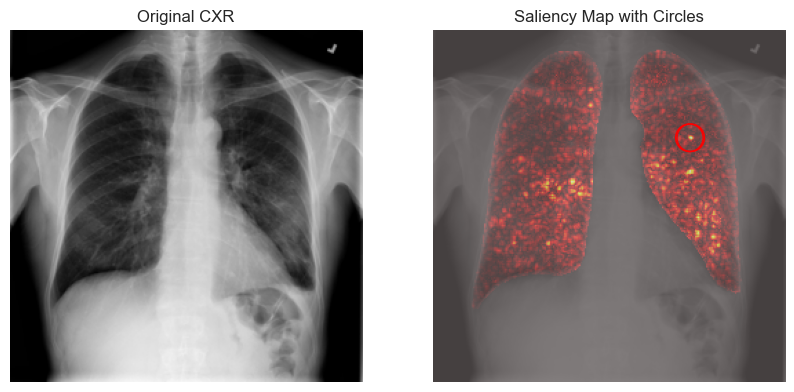

Percentage of lung infected: 5.89%


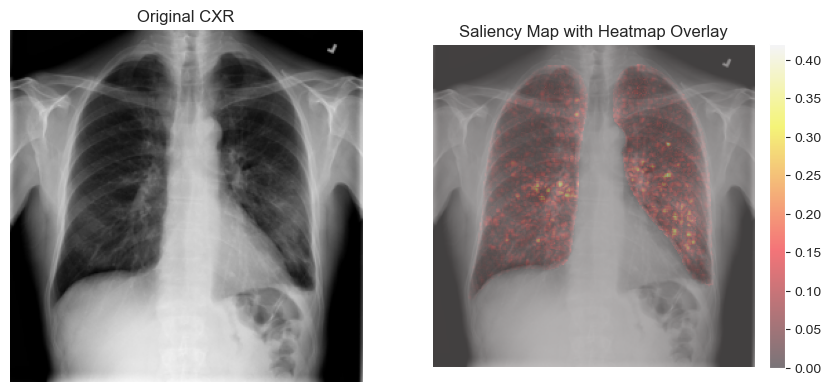

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from captum.attr import Saliency, GuidedGradCam
import numpy as np
import matplotlib.pyplot as plt
from torchray.attribution.grad_cam import grad_cam

# Define the file paths of the image and mask
# image_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/image/covid_976.png'
# mask_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/mask/covid_976.png'

image_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/image/non_COVID (3266).png'
mask_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/mask/non_COVID (3266).png'

# image_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/image/Normal (20).png'
# mask_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/mask/Normal (20).png'


# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
preprocessed_image = transform(image)
input_tensor = torch.unsqueeze(preprocessed_image, 0)


# Load the saved model
model_path = 'C:/Users/shorb/PycharmProjects/thesis/metric/Ensamble/shom/Ensemble_full.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path, map_location=device)
model.to(device)

# Pass the input tensor through the model
input_tensor = input_tensor.to(device)
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)

# Get the predicted class and associated probability
predicted_class = train_dataset.class_names[predicted.item()]
probability = torch.softmax(outputs, dim=1)[0, predicted].item()

# Print the predicted class and probability
print(f'Predicted Class: {predicted_class}')
print(f'Probability: {probability:.4f}')

# Load and preprocess the lung mask
mask = Image.open(mask_path).convert('L')
mask_tensor = transforms.ToTensor()(mask)
mask_tensor = transforms.Resize(size=(256, 256))(mask_tensor)
mask_tensor = torch.unsqueeze(mask_tensor, 0).to(device)

# Create a Saliency instance
saliency = Saliency(model)

# Generate saliency map
saliency_map = saliency.attribute(input_tensor, target=predicted)

# Normalize the saliency map
saliency_map = saliency_map.detach().cpu().numpy()
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Transpose the saliency map to match the image dimensions
saliency_map = saliency_map.transpose(0, 2, 3, 1)

# Convert the saliency map to grayscale
saliency_gray = np.mean(saliency_map[0], axis=2)

# Apply the lung mask to the saliency map
masked_saliency_map = saliency_gray * mask_tensor.squeeze().cpu().numpy()

# Calculate the percentage of the lung that is infected
infected_percentage = np.sum(masked_saliency_map) / np.sum(mask_tensor.cpu().numpy())

# Create a figure with subplots for original image and saliency map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Original CXR')

# Plot the saliency map with circles around areas of interest
axes[1].imshow(image, alpha=0.5)
axes[1].imshow(masked_saliency_map, cmap='hot', alpha=0.5)
axes[1].axis('off')
axes[1].set_title('Saliency Map with Circles')

# Get the coordinates of the regions with high saliency
threshold = 0.4  # Adjust this threshold as needed
high_saliency_coords = np.where(masked_saliency_map > threshold)

# Add circles around the regions with high saliency
for y, x in zip(*high_saliency_coords):
    circle = plt.Circle((x, y), radius=10, color='red', fill=False)
    axes[1].add_patch(circle)

plt.show()

# Print the percentage of the lung that is infected
print(f'Percentage of lung infected: {infected_percentage * 100:.2f}%')

# ---------------------------------------------------------------------------

# Create a figure with subplots for original image and saliency map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Original CXR')

# Plot the saliency map with heatmap overlay
heatmap = axes[1].imshow(masked_saliency_map, cmap='hot', alpha=0.5)
axes[1].imshow(image, alpha=0.5)

# Add a color bar to the heatmap
plt.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

# Get the coordinates of the regions with high saliency
threshold = 0.6  # Adjust this threshold as needed
high_saliency_coords = np.where(masked_saliency_map > threshold)

# Add circles around the regions with high saliency
for y, x in zip(*high_saliency_coords):
    circle = plt.Circle((x, y), radius=10, color='red', fill=False)
    axes[1].add_patch(circle)

# Set titles and axis labels
axes[1].axis('off')
axes[1].set_title('Saliency Map with Heatmap Overlay')

plt.show()
# -----------------------------------------------------------------------





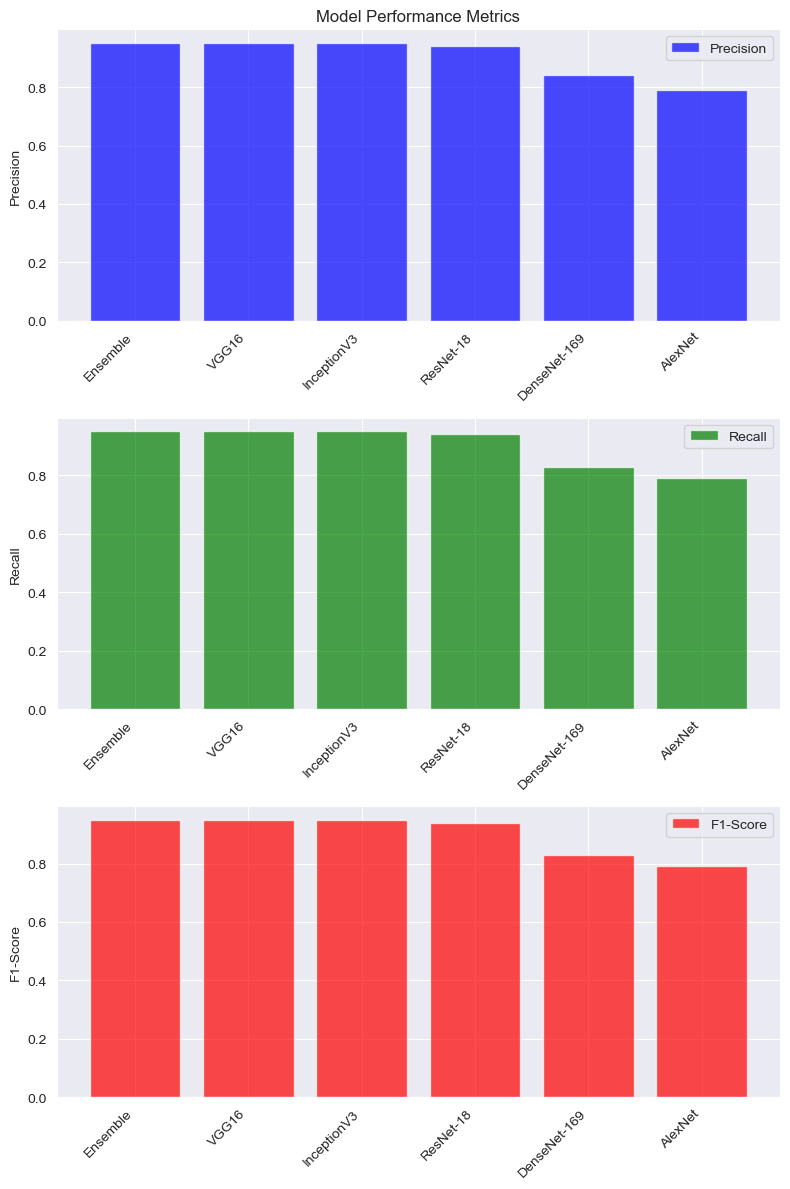

In [ ]:
import matplotlib.pyplot as plt

# Model names and corresponding performance metrics
models = ['Ensemble', 'VGG16', 'InceptionV3', 'ResNet-18', 'DenseNet-169', 'AlexNet']
precision = [0.95, 0.95, 0.95, 0.94, 0.84, 0.79]
recall = [0.95, 0.95, 0.95, 0.94, 0.83, 0.79]
f1_score = [0.95, 0.95, 0.95, 0.94, 0.83, 0.79]

# Bar chart positions
x = range(len(models))

# Create subplots for Precision, Recall, and F1-Score
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Precision
axs[0].bar(x, precision, color='b', alpha=0.7, label='Precision')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45, ha='right')
axs[0].set_ylabel('Precision')
axs[0].set_title('Model Performance Metrics')
axs[0].legend()

# Plot Recall
axs[1].bar(x, recall, color='g', alpha=0.7, label='Recall')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45, ha='right')
axs[1].set_ylabel('Recall')
axs[1].legend()

# Plot F1-Score
axs[2].bar(x, f1_score, color='r', alpha=0.7, label='F1-Score')
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=45, ha='right')
axs[2].set_ylabel('F1-Score')
axs[2].legend()

plt.tight_layout()
plt.show()
